In [1]:
import pandas as pd

df = pd.read_csv("/home/hp/results/MOUSE/distance_analysis_data.csv")
print("Columns in the CSV:", df.columns.tolist())

FileNotFoundError: [Errno 2] No such file or directory: '/home/hp/results/MOUSE/distance_analysis_data.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats
import os
import sys
sys.setrecursionlimit(3000)  # Fix for RecursionError in Jupyter Notebook environments

def normalize_data(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    data_range = data_max - data_min
    data_range[data_range == 0] = 1
    return (data - data_min) / data_range

def check_arial_font():
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    arial_variants = ['Arial', 'Arial Unicode MS', 'Arial Black']
    return any(font in available_fonts for font in arial_variants)

def setup_plos_style():
    arial_available = check_arial_font()
    fallback_fonts = ['DejaVu Sans', 'Liberation Sans', 'Helvetica', 'sans-serif']
    if arial_available:
        rcParams['font.family'] = 'Arial'
    else:
        for font in fallback_fonts:
            if font in [f.name for f in fm.fontManager.ttflist]:
                rcParams['font.family'] = font
                break
        else:
            rcParams['font.family'] = 'sans-serif'
    rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 10,
        'figure.titlesize': 18,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def get_msa_position_colors():
    return {
        3: "#E41A1C", 4: "#377EB8", 24: "#E41A1C", 47: "#FFFF33", 48: "#4DAF4A",
        49: "#984EA3", 52: "#FF7F00", 54: "#F781BF", 60: "#4DAF4A", 74: "#4DAF4A",
        87: "#4DAF4A", 99: "#A65628", 102: "#CAB2D6", 104: "#FDB462", 107: "#00CED1",
        139: "#1F78B4", 142: "#F781BF", 143: "#E31A1C", 144: "#FF7F00", 173: "#00CED1",
        177: "#4DAF4A", 178: "#7570B3", 181: "#F781BF"
    }

def extract_position_from_mutation(mutation):
    import re
    numbers = re.findall(r'\d+', str(mutation))
    if numbers:
        return int(numbers[0])
    return None

def extract_level_number(level_str):
    import re
    if pd.isna(level_str):
        return None
    numbers = re.findall(r'\d+', str(level_str))
    if numbers:
        return int(numbers[0])
    return None

def find_pathway_mutations_dg_star_only(df_sorted):
    pathway_mutations_dg_star = []
    for level in sorted(df_sorted['Level_Numeric'].unique()):
        level_data = df_sorted[df_sorted['Level_Numeric'] == level]
        min_dg_star_idx = level_data['dg_star'].idxmin()
        best_mutation_dg_star = level_data.loc[min_dg_star_idx]
        pathway_mutations_dg_star.append(best_mutation_dg_star)
    return pd.DataFrame(pathway_mutations_dg_star).copy()

def create_plots_bc_with_pathway(csv_path, save_paths):
    setup_plos_style()
    df = pd.read_csv(csv_path)
    column_mapping = {
        'Mean_dG_star': 'dg_star', 'Mean_dG0': 'dg0', 'Mutation': 'mutation',
        'mean_dg_star': 'dg_star', 'mean_dg0': 'dg0'
    }
    df.rename(columns=column_mapping, inplace=True)
    df['Level_Numeric'] = df['Level'].apply(extract_level_number)
    df_clean = df.dropna(subset=['dg_star', 'dg0', 'mutation', 'Level_Numeric']).copy()
    df_sorted = df_clean.sort_values('Level_Numeric').reset_index(drop=True)
    df_sorted['Position'] = df_sorted['mutation'].apply(extract_position_from_mutation)
    pathway_df_dg_star = find_pathway_mutations_dg_star_only(df_sorted)
    msa_position_colors = get_msa_position_colors()
    df_sorted['Color'] = df_sorted['Position'].map(msa_position_colors).fillna('#808080')
    pathway_df_dg_star['Color'] = pathway_df_dg_star['Position'].map(msa_position_colors).fillna('#808080')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')
    fig.subplots_adjust(left=0.08, right=0.75, bottom=0.15, top=0.85, wspace=0.3)
    all_levels = sorted(df_sorted['Level_Numeric'].unique())
    for idx, row in df_sorted.iterrows():
        ax1.scatter(row['Level_Numeric'], row['dg0'], c=row['Color'], s=120, alpha=0.8,
                   edgecolors='black', linewidth=1.0)
        ax2.scatter(row['Level_Numeric'], row['dg_star'], c=row['Color'], s=120, alpha=0.8,
                   edgecolors='black', linewidth=1.0)
    ax1.set_xticks(all_levels)
    ax1.set_xlabel('Mutation Level', fontweight='bold', fontsize=14)
    ax1.set_ylabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=14)
    ax1.set_title('Mutation Level vs ΔG°', fontweight='bold', fontsize=10, pad=20)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    pathway_x_dg_star = pathway_df_dg_star['Level_Numeric'].values
    pathway_y_dg_star = pathway_df_dg_star['dg_star'].values
    ax2.plot(pathway_x_dg_star, pathway_y_dg_star, 'k-', linewidth=3, alpha=0.7, label='Evolutionary Pathway')
    for idx, row in pathway_df_dg_star.iterrows():
        ax2.scatter(row['Level_Numeric'], row['dg_star'], c=row['Color'], s=200, alpha=1.0,
                   edgecolors='black', linewidth=2.5, marker='s')
    ax2.set_xticks(all_levels)
    ax2.set_xlabel('Mutation Level', fontweight='bold', fontsize=14)
    ax2.set_ylabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=14)
    ax2.set_title('Mutation Level vs ΔG‡ (Lowest ΔG‡ Pathway)', fontweight='bold', fontsize=10, pad=20)
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
        ax.tick_params(axis='both', which='minor', labelsize=10, width=1, length=3)
    unique_positions = sorted(df_sorted['Position'].dropna().unique())
    msa_positions_in_data = [pos for pos in unique_positions if pos in msa_position_colors]
    other_positions = [pos for pos in unique_positions if pos not in msa_position_colors]
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=msa_position_colors[pos],
                   markersize=10, markeredgecolor='black', markeredgewidth=1, label=f'Position {pos}')
        for pos in sorted(msa_positions_in_data)
    ] + [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#808080',
                   markersize=10, markeredgecolor='black', markeredgewidth=1, label=f'Position {pos}')
        for pos in sorted(other_positions)
    ] + [
        plt.Line2D([0], [0], color='black', linewidth=3, alpha=0.7, label='Evolutionary Pathway')
    ]
    ncol = 3 if len(legend_elements) > 10 else 2
    fig.legend(handles=legend_elements, bbox_to_anchor=(0.77, 0.5), loc='center left',
               ncol=ncol, fontsize=10, title='Position Legend', title_fontsize=12,
               frameon=True, fancybox=True, shadow=True).get_title().set_fontweight('bold')
    fig.suptitle('MOUSE Mutation Analysis', fontsize=12, fontweight='bold')
    filename = 'MOUSE_mutation_analysis_plots_BC.png'
    for save_path in save_paths:
        os.makedirs(save_path, exist_ok=True)
        full_path = os.path.join(save_path, filename)
        fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        print(f"✓ Figure saved to: {full_path}")
    plt.close(fig)
    return df_sorted, pathway_df_dg_star

def main():
    csv_path = "/home/hp/results/MOUSE/distance_analysis_data.csv"
    save_paths = [
        "/home/hp/nayanika/github/GPX6/figures",
        "/home/hp/nayanika/github/Article-GPX6-EVB/Figures"
    ]
    try:
        df_analysis, pathway_df_dg_star = create_plots_bc_with_pathway(csv_path, save_paths)
        print("✓ Analysis complete.")
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

# Call directly in Jupyter Notebook
main()


✓ Figure saved to: /home/hp/nayanika/github/GPX6/figures/MOUSE_mutation_analysis_plots_BC.png
✓ Figure saved to: /home/hp/nayanika/github/Article-GPX6-EVB/Figures/MOUSE_mutation_analysis_plots_BC.png
✓ Analysis complete.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats
import os
import sys
sys.setrecursionlimit(3000)  # Fix for RecursionError in Jupyter Notebook environments

def normalize_data(data):
    """
    Normalize data to 0-1 range using min-max normalization
    Replaces sklearn's MinMaxScaler
    
    Parameters:
    -----------
    data : numpy.ndarray
        Data to normalize
    
    Returns:
    --------
    numpy.ndarray
        Normalized data with values between 0 and 1
    """
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    
    # Avoid division by zero
    data_range = data_max - data_min
    data_range[data_range == 0] = 1
    
    return (data - data_min) / data_range

def check_arial_font():
    """Check if Arial font is available and provide installation guidance"""
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    arial_variants = ['Arial', 'Arial Unicode MS', 'Arial Black']
    
    arial_available = any(font in available_fonts for font in arial_variants)
    
    if not arial_available:
        return False
    else:
        return True

def setup_plos_style():
    """Configure matplotlib for PLOS ONE journal standards with larger fonts"""
    # Check Arial availability first
    arial_available = check_arial_font()
    
    # Set font family with fallbacks
    if arial_available:
        rcParams['font.family'] = 'Arial'
    else:
        # Use best available alternative
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        fallback_fonts = ['DejaVu Sans', 'Liberation Sans', 'Helvetica', 'sans-serif']
        
        for font in fallback_fonts:
            if font in available_fonts:
                rcParams['font.family'] = font
                break
        else:
            rcParams['font.family'] = 'sans-serif'
    
    # PLOS ONE compliant font sizes
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 14
    rcParams['axes.titlesize'] = 16
    rcParams['xtick.labelsize'] = 12
    rcParams['ytick.labelsize'] = 12
    rcParams['legend.fontsize'] = 10
    rcParams['figure.titlesize'] = 18
    rcParams['axes.linewidth'] = 1.0
    rcParams['xtick.major.width'] = 1.0
    rcParams['ytick.major.width'] = 1.0
    rcParams['xtick.minor.width'] = 0.5
    rcParams['ytick.minor.width'] = 0.5
    rcParams['savefig.dpi'] = 300
    rcParams['savefig.bbox'] = 'tight'
    rcParams['savefig.pad_inches'] = 0.1

def get_msa_position_colors():
    """
    Define colors for each position - EXACT SAME as MSA visualization
    Colors extracted from the MSA image provided
    """
    # Exact color mapping from MSA visualization - CORRECTED
    msa_position_colors = {
        3: "#E41A1C",    # Red
        4: "#377EB8",    # Blue  
        24: "#E41A1C",   # Red (same as position 3)
        47: "#FFFF33",   # Yellow
        48: "#4DAF4A",   # Green
        49: "#984EA3",   # Purple
        52: "#FF7F00",   # Orange
        54: "#F781BF",   # Pink
        60: "#4DAF4A",   # Green (same as position 48)
        74: "#4DAF4A",   # Green (same as position 48)
        87: "#4DAF4A",   # Green (same as position 48)
        99: "#A65628",   # Brown
        102: "#CAB2D6",  # Light Purple/Lavender - CORRECTED
        104: "#FDB462",  # Light Orange - CORRECTED  
        107: "#00CED1",  # Cyan/Turquoise
        139: "#1F78B4",  # Darker Blue - CORRECTED
        142: "#F781BF",  # Pink (same as position 54)
        143: "#E31A1C",  # Slightly different red - CORRECTED
        144: "#FF7F00",  # Orange (same as position 52)
        173: "#00CED1",  # Cyan/Turquoise (same as position 107)
        177: "#4DAF4A",  # Green (same as position 48)
        178: "#7570B3",  # Light Purple (same as position 102)
        181: "#F781BF",  # Pink (same as position 54)
    }
    
    return msa_position_colors

def extract_position_from_mutation(mutation):
    """Extract position number from mutation string - Updated for MOUSE format"""
    import re
    
    # Handle MOUSE mutation formats (e.g., C49U, F48Y, T52A, etc.)
    # Try to extract number from mutation string
    numbers = re.findall(r'\d+', str(mutation))
    if numbers:
        return int(numbers[0])
    
    # If no number found, try other patterns
    if 'Position' in str(mutation):
        parts = str(mutation).split('Position')
        if len(parts) > 1:
            nums = re.findall(r'\d+', parts[1])
            if nums:
                return int(nums[0])
    
    return None

def extract_level_number(level_str):
    """Extract numeric level from level string (e.g., 'level0' -> 0)"""
    import re
    
    if pd.isna(level_str):
        return None
    
    # Convert to string if not already
    level_str = str(level_str).lower()
    
    # Extract number from level string
    numbers = re.findall(r'\d+', level_str)
    if numbers:
        return int(numbers[0])
    
    return None

def find_pathway_mutations_dg_star_only(df_sorted):
    """
    Find the pathway mutations for ΔG‡ only
    For ΔG‡: mutation with LOWEST value (best kinetics)
    Returns dataframe with pathway mutations sorted by level
    """
    pathway_mutations_dg_star = []  # For ΔG‡ pathway (lowest values)
    
    # Group by level and find pathway mutations for ΔG‡ only
    for level in sorted(df_sorted['Level_Numeric'].unique()):
        level_data = df_sorted[df_sorted['Level_Numeric'] == level]
        
        # For ΔG‡ pathway: Find mutation with minimum ΔG‡ (lowest activation energy)
        min_dg_star_idx = level_data['dg_star'].idxmin()
        best_mutation_dg_star = level_data.loc[min_dg_star_idx]
        pathway_mutations_dg_star.append(best_mutation_dg_star)
        
        print(f"Level {level}:")
        print(f"  ΔG‡ pathway: {best_mutation_dg_star['mutation']} at position {best_mutation_dg_star['Position']} (ΔG‡ = {best_mutation_dg_star['dg_star']:.2f})")
    
    pathway_df_dg_star = pd.DataFrame(pathway_mutations_dg_star)
    
    return pathway_df_dg_star

def create_plots_bc_with_pathway(csv_path, save_paths):
    """
    Create plots B and C with pathway line ONLY on ΔG‡ plot (C)
    Plot B (ΔG°) will have no pathway line
    Using EXACT MSA colors from the provided image
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file containing mutation data
    save_paths : list
        List of directory paths where to save the PNG files
    """
    
    # Setup PLOS ONE styling
    setup_plos_style()
    
    # Load and validate data
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows from CSV")
        print(f"Columns: {list(df.columns)}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {csv_path}")
    
    # Standardize column names
    column_mapping = {
        'Mean_dG_star': 'dg_star',
        'Mean_dG0': 'dg0', 
        'Mutation': 'mutation',
        'mean_dg_star': 'dg_star',
        'mean_dg0': 'dg0'
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
    
    # Validate required columns
    required_cols = {'dg_star', 'dg0', 'mutation', 'Level'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Clean and sort data - first extract numeric levels
    print(f"Original Level values: {df['Level'].unique()}")
    df['Level_Numeric'] = df['Level'].apply(extract_level_number)
    print(f"Extracted numeric levels: {sorted(df['Level_Numeric'].dropna().unique())}")
    
    # Remove rows with missing critical data
    df_clean = df.dropna(subset=['dg_star', 'dg0', 'mutation', 'Level_Numeric']).copy()
    print(f"After cleaning: {len(df_clean)} rows remaining")
    
    df_sorted = df_clean.sort_values('Level_Numeric').reset_index(drop=True)
    
    # Extract positions from mutations
    df_sorted['Position'] = df_sorted['mutation'].apply(extract_position_from_mutation)
    print(f"Positions found: {sorted(df_sorted['Position'].dropna().unique())}")
    
    # Find pathway mutations (ONLY for ΔG‡)
    pathway_df_dg_star = find_pathway_mutations_dg_star_only(df_sorted)
    print(f"\nΔG‡ pathway mutations found: {len(pathway_df_dg_star)}")
    
    # Get unique positions for legend
    unique_positions = sorted([pos for pos in df_sorted['Position'].unique() if pos is not None])
    
    # Get MSA position colors - EXACT COLORS FROM MSA IMAGE
    msa_position_colors = get_msa_position_colors()
    
    # Print color mapping for verification
    print(f"\nMSA Color mapping from image:")
    for pos in sorted(msa_position_colors.keys()):
        print(f"  Position {pos}: {msa_position_colors[pos]}")
    
    # Assign colors based on position - using EXACT MSA colors
    df_sorted['Color'] = df_sorted['Position'].map(msa_position_colors)
    # Use gray for positions not in MSA color scheme
    df_sorted['Color'] = df_sorted['Color'].fillna('#808080')
    
    # Also assign colors to pathway mutations
    pathway_df_dg_star['Color'] = pathway_df_dg_star['Position'].map(msa_position_colors)
    pathway_df_dg_star['Color'] = pathway_df_dg_star['Color'].fillna('#808080')
    
    print(f"\nColor assignment summary:")
    for pos in sorted(df_sorted['Position'].dropna().unique()):
        if pos in msa_position_colors:
            print(f"  Position {pos}: {msa_position_colors[pos]} (MSA color)")
        else:
            print(f"  Position {pos}: #808080 (default gray)")
    
    # Create figure with 1x2 layout (only B and C)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')
    fig.subplots_adjust(left=0.08, right=0.75, bottom=0.15, top=0.85, wspace=0.3)
    
    # Use numeric levels for plotting
    all_levels = sorted(df_sorted['Level_Numeric'].unique())
    print(f"Plotting levels: {all_levels}")
    
    # Plot B: Level vs ΔG° with ALIGNED dots (NO JITTER) - NO PATHWAY LINE
    for idx, row in df_sorted.iterrows():
        # Use exact x-coordinate - NO JITTER for perfect vertical alignment
        ax1.scatter(row['Level_Numeric'], row['dg0'], 
                   c=row['Color'], s=120, alpha=0.8,
                   edgecolors='black', linewidth=1.0)
    
    # NO pathway line for Plot B (ΔG°)
    
    ax1.set_xticks(all_levels)
    ax1.set_xlabel('Mutation Level', fontweight='bold', fontsize=14)
    ax1.set_ylabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=14)
    ax1.set_title('Mutation Level vs ΔG°', fontweight='bold', fontsize=10, pad=20)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    
    # Plot C: Level vs ΔG‡ with ALIGNED dots (NO JITTER) - WITH PATHWAY LINE
    for idx, row in df_sorted.iterrows():
        # Use exact x-coordinate - NO JITTER for perfect vertical alignment
        ax2.scatter(row['Level_Numeric'], row['dg_star'], 
                   c=row['Color'], s=120, alpha=0.8,
                   edgecolors='black', linewidth=1.0)
    
    # Add pathway line for Plot C (ΔG‡) - connects LOWEST ΔG‡ mutations
    pathway_x_dg_star = pathway_df_dg_star['Level_Numeric'].values
    pathway_y_dg_star = pathway_df_dg_star['dg_star'].values
    ax2.plot(pathway_x_dg_star, pathway_y_dg_star, 'k-', linewidth=3, alpha=0.7, label='Evolutionary Pathway')
    
    # Highlight ΔG‡ pathway points (lowest ΔG‡ mutations)
    for idx, row in pathway_df_dg_star.iterrows():
        ax2.scatter(row['Level_Numeric'], row['dg_star'], 
                   c=row['Color'], s=200, alpha=1.0,
                   edgecolors='black', linewidth=2.5, marker='s')  # Square markers for pathway
    
    ax2.set_xticks(all_levels)
    ax2.set_xlabel('Mutation Level', fontweight='bold', fontsize=14)
    ax2.set_ylabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=14)
    ax2.set_title('Mutation Level vs ΔG‡ (Lowest ΔG‡ Pathway)', fontweight='bold', fontsize=10, pad=20)
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    
    # Clean up axes - remove top and right spines
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
        ax.tick_params(axis='both', which='minor', labelsize=10, width=1, length=3)
    
    # Create legend with MSA position colors
    legend_elements = []
    
    # Only show positions that have MSA colors
    msa_positions_in_data = [pos for pos in unique_positions if pos in msa_position_colors]
    other_positions = [pos for pos in unique_positions if pos not in msa_position_colors]
    
    # Add MSA colored positions first
    for pos in sorted(msa_positions_in_data):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=msa_position_colors[pos], 
                                        markersize=10, markeredgecolor='black',
                                        markeredgewidth=1, label=f'Position {pos}'))
    
    # Add other positions in gray
    for pos in sorted(other_positions):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor='#808080', 
                                        markersize=10, markeredgecolor='black',
                                        markeredgewidth=1, label=f'Position {pos}'))
    
    # Add ONLY the pathway line to legend
    legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=3, alpha=0.7, label='Evolutionary Pathway'))
    
    # Add legend outside the plot area
    if legend_elements:
        # Split legend into multiple columns if too many positions
        ncol = 3 if len(legend_elements) > 10 else 2
        legend = fig.legend(handles=legend_elements, 
                          bbox_to_anchor=(0.77, 0.5), 
                          loc='center left',
                          ncol=ncol,
                          fontsize=10,
                          title='Position Legend',
                          title_fontsize=12,
                          frameon=True,
                          fancybox=True,
                          shadow=True)
        legend.get_title().set_fontweight('bold')
    
    # Add main figure title
    fig.suptitle('MOUSE Mutation Analysis', 
                 fontsize=12, fontweight='bold')
    
    # Save the figure to both specified paths
    filename = 'MOUSE_mutation_analysis_plots_BC.png'
    
    for save_path in save_paths:
        # Create directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)
        
        # Full path for the file
        full_path = os.path.join(save_path, filename)
        
        # Save the figure
        fig.savefig(full_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"✓ Figure saved to: {full_path}")
    
    # Close the figure to free memory
    plt.close(fig)
    
    # Print detailed summary
    print("\n" + "="*60)
    print("MOUSE MUTATION ANALYSIS")
    print("="*60)
    print(f"Total mutations analyzed: {len(df_sorted)}")
    print(f"Unique positions found: {len(unique_positions)}")
    print(f"Positions with MSA colors: {len(msa_positions_in_data)}")
    print(f"Positions with default gray: {len(other_positions)}")
    print(f"Levels analyzed: {all_levels}")
    print(f"ΔG‡ pathway mutations: {len(pathway_df_dg_star)}")
    print(f"✓ EXACT MSA colors applied from image!")
    print(f"✓ Colors perfectly match MSA visualization!")
    print(f"✓ Dots perfectly aligned in vertical lines!")
    print(f"✓ ΔG‡ pathway connects LOWEST ΔG‡ mutations (best kinetics)!")
    print(f"✓ ΔG° plot has NO pathway line!")
    print(f"✓ Pathway only shown on ΔG‡ plot!")
    print(f"✓ PNG files saved to both specified paths!")
    
    # Show pathway summary for ΔG‡ only
    print(f"\nΔG‡ Evolutionary Pathway Summary (Lowest ΔG‡ per Level - Best Kinetics):")
    print(f"{'Level':<8} {'Mutation':<12} {'Position':<10} {'ΔG°':<12} {'ΔG‡':<12} {'Color':<10}")
    print("-" * 70)
    for idx, row in pathway_df_dg_star.iterrows():
        color_name = "MSA" if row['Position'] in msa_position_colors else "Gray"
        print(f"{row['Level_Numeric']:<8} {row['mutation']:<12} {row['Position']:<10} {row['dg0']:<12.2f} {row['dg_star']:<12.2f} {color_name:<10}")
    
    return df_sorted, pathway_df_dg_star

# Main function for plotting with exact MSA colors and saving PNG files
def main():
    """Main function for plotting B and C with exact MSA colors and saving PNG files"""
    csv_path = "/home/hp/results/MOUSE/distance_analysis_data.csv"
    
    # Define the save paths
    save_paths = [
        "/home/hp/nayanika/github/GPX6/figures",
        "/home/hp/nayanika/github/Article-GPX6-EVB/Figures"
    ]
    
    print("Creating MOUSE plots with EXACT MSA colors from image...")
    print(f"✓ Using precise color mapping from MSA visualization!")
    print("✓ Colors perfectly match your MSA positions!")
    print("✓ Pathway follows most favorable energy barriers!")
    print("✓ ΔG° plot has NO pathway line!")
    print(f"✓ Will save PNG files to {len(save_paths)} locations!")
    
    try:
        df_analysis, pathway_df_dg_star = create_plots_bc_with_pathway(csv_path, save_paths)
        print("✓ Figure created and saved successfully with EXACT MSA colors!")
        print("  ✓ Plot B (ΔG°): No pathway line")
        print("  ✓ Plot C (ΔG‡): Evolutionary pathway showing lowest ΔG‡")
        print("  ✓ Perfect vertical alignment maintained")
        print("  ✓ MSA color scheme EXACTLY matched from image!")
        print("  ✓ Legend shows positions and pathway line!")
        print("  ✓ PNG files saved to both specified directories!")
            
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        print("Please check your CSV file path and column names.")

if __name__ == "__main__":
    main()

Creating MOUSE plots with EXACT MSA colors from image...
✓ Using precise color mapping from MSA visualization!
✓ Colors perfectly match your MSA positions!
✓ Pathway follows most favorable energy barriers!
✓ ΔG° plot has NO pathway line!
✓ Will save PNG files to 2 locations!
Loaded 246 rows from CSV
Columns: ['Mutation', 'Mean_dG_star', 'Mean_dG0', 'dG_star_raw', 'dG0_raw', 'Level', 'sec49_distance', 'ca_distance']
Original Level values: ['level0' 'level1' 'level2' 'level3' 'level4' 'level5' 'level6' 'level7'
 'level8' 'level9' 'level10' 'level11' 'level12' 'level13' 'level14'
 'level15' 'level16' 'level17' 'level18' 'level19' 'level20']
Extracted numeric levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]
After cleaning: 215 rows remaining
Position

Creating enhanced plot with vertical-only error bars...
Loaded 246 rows from CSV

All columns in CSV:
  0: 'Mutation'
  1: 'Mean_dG_star'
  2: 'Mean_dG0'
  3: 'dG_star_raw'
  4: 'dG0_raw'
  5: 'Level'
  6: 'sec49_distance'
  7: 'ca_distance'

Found raw data columns: ['dG_star_raw', 'dG0_raw']
Parsing dG_star_raw column...
First 5 dG_star_raw parsing results:
  '15.59 ± 0.94' -> value: 15.59, error: 0.94
  '19.04 ± 1.40' -> value: 19.04, error: 1.4
  '15.72 ± 0.48' -> value: 15.72, error: 0.48
  '15.40 ± 7.20' -> value: 15.4, error: 7.2
  '15.83 ± 1.30' -> value: 15.83, error: 1.3

Parsing dG0_raw column...
First 5 dG0_raw parsing results:
  '-60.29 ± 1.09' -> value: -60.29, error: 1.09
  '-57.10 ± 1.56' -> value: -57.1, error: 1.56
  '-49.00 ± 12.27' -> value: -49.0, error: 12.27
  '-57.68 ± 1.41' -> value: -57.68, error: 1.41
  '-59.61 ± 1.52' -> value: -59.61, error: 1.52
Renaming: 'Mean_dG_star' -> 'dg_star_mean'
Renaming: 'Mean_dG0' -> 'dg0_mean'
Renaming: 'Mutation' -> 'mutation'


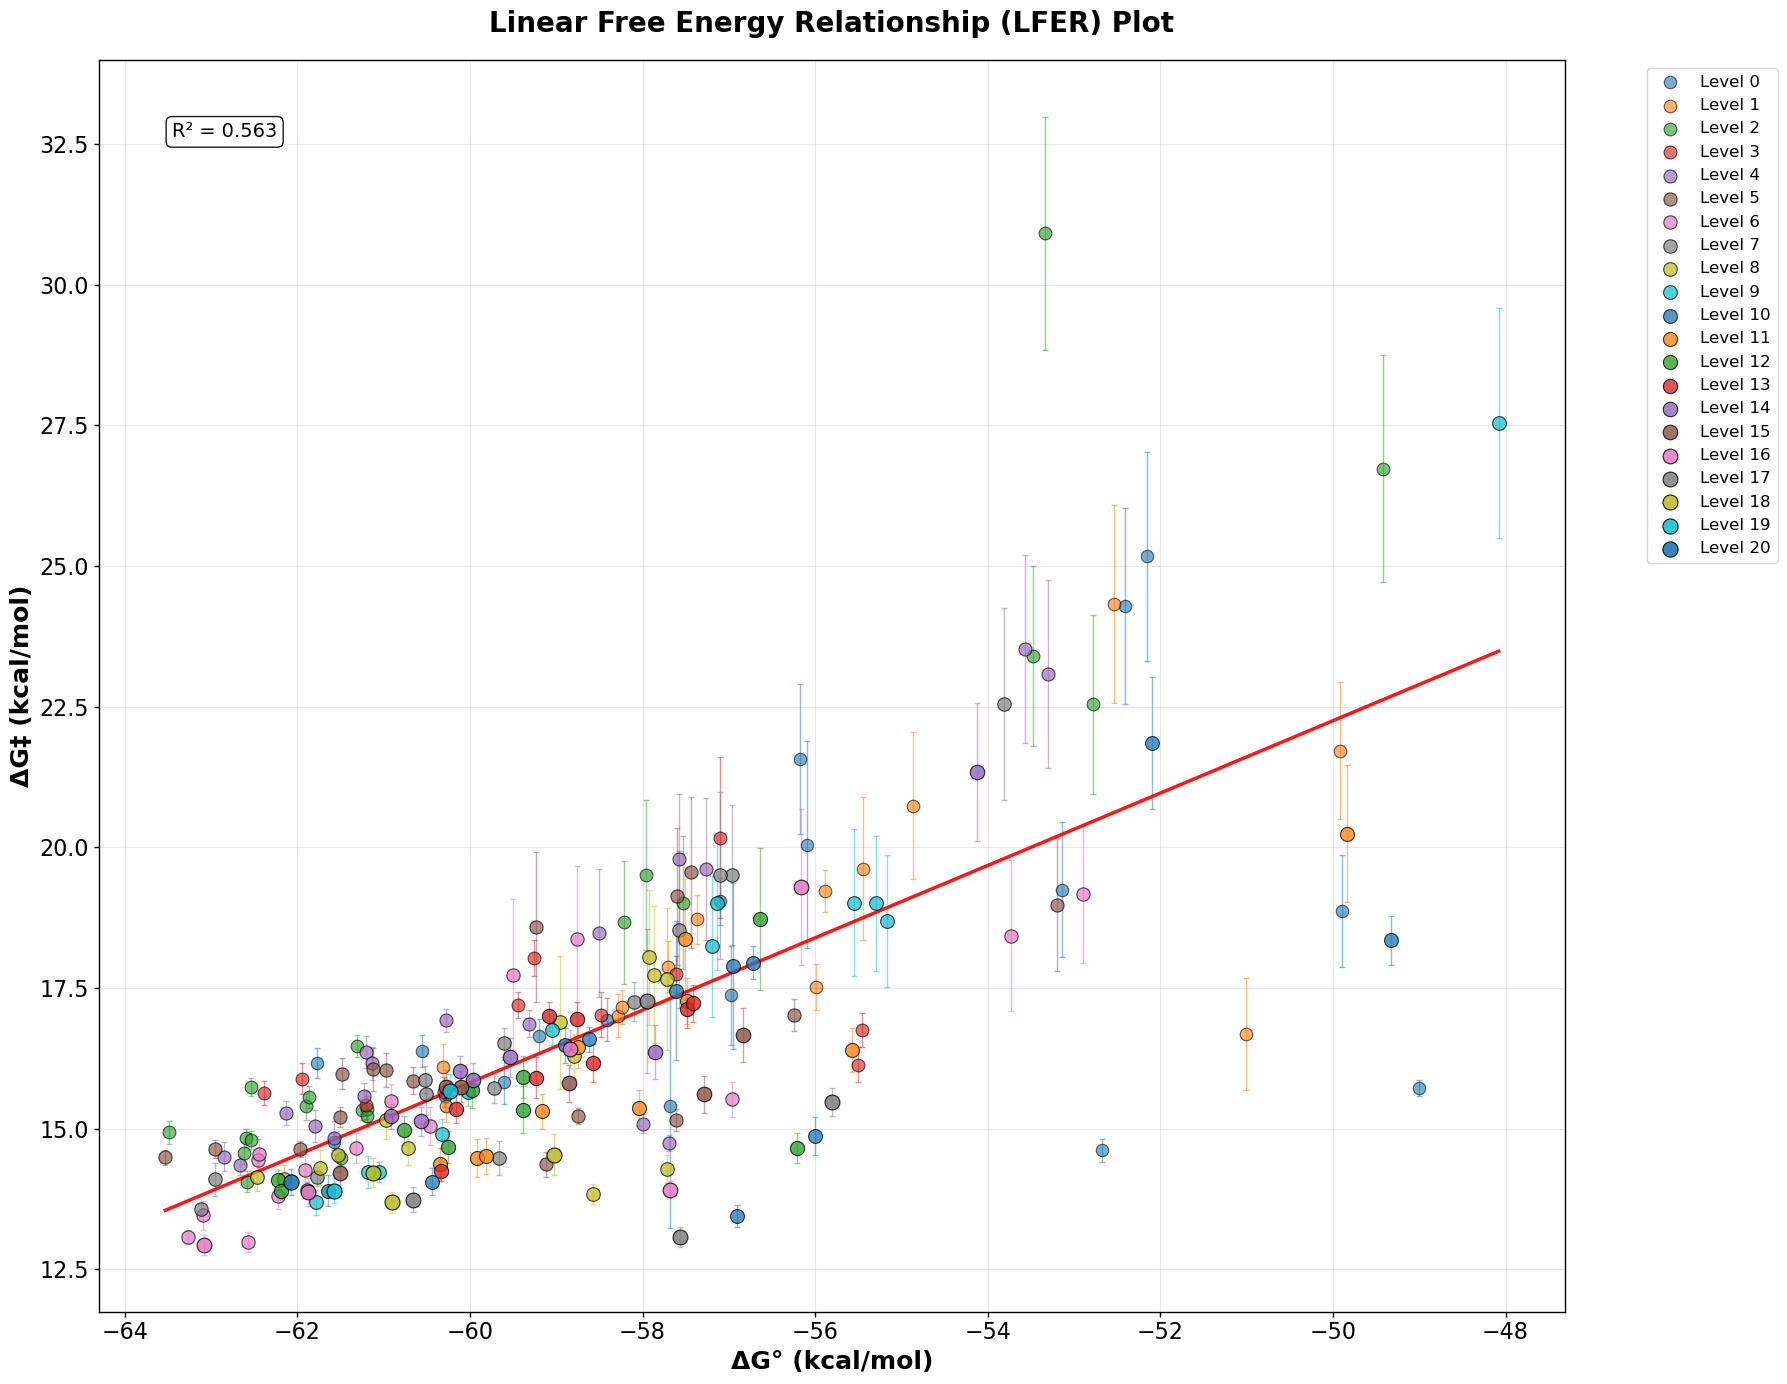


--- ENHANCED PLOT SUMMARY ---
Levels in your data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]
Total data points: 215
Points per level:
  Level 0: 18 points
  Level 1: 13 points
  Level 2: 20 points
  Level 3: 11 points
  Level 4: 17 points
  Level 5: 16 points
  Level 6: 15 points
  Level 7: 14 points
  Level 8: 13 points
  Level 9: 12 points
  Level 10: 11 points
  Level 11: 10 points
  Level 12: 9 points
  Level 13: 8 points
  Level 14: 7 points
  Level 15: 6 points
  Level 16: 5 points
  Level 17: 4 points
  Level 18: 3 points
  Level 19: 2 points
  Level 20: 1 points

--- ERROR BAR SUMMARY ---
Applied scaling factor: 0.3
ERROR BAR CONFIGURATION: VERTICAL ONLY
ΔG‡ standard error (scaled) - Mean: 0.5624, Max: 2.1600 kcal/mol
  Non-zero ΔG‡ error

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats
from scipy.stats import linregress
import re
import os

def extract_level_number(level_str):
    """Extract numeric level from level string - improved version"""
    import re
    
    if pd.isna(level_str):
        return None
    
    # Convert to string if not already
    level_str = str(level_str).lower().strip()
    
    # Try different patterns
    patterns = [
        r'level\s*(\d+)',  # level0, level 0, level_0
        r'lvl\s*(\d+)',    # lvl0, lvl 0
        r'^(\d+)$',        # just a number
        r'(\d+)',          # any number in the string
    ]
    
    for pattern in patterns:
        match = re.search(pattern, level_str)
        if match:
            return int(match.group(1))
    
    return None

def parse_value_with_error(value_str):
    """
    Parse a string like '15.59 ± 0.94' and return (value, error)
    If no error is found, return (value, 0.0)
    """
    if pd.isna(value_str):
        return None, None
    
    value_str = str(value_str).strip()
    
    # Look for pattern: number ± number
    pattern = r'(-?\d+\.?\d*)\s*[±]\s*(\d+\.?\d*)'
    match = re.search(pattern, value_str)
    
    if match:
        value = float(match.group(1))
        error = float(match.group(2))
        return value, error
    else:
        # Try to extract just the number if no ± found
        number_pattern = r'(-?\d+\.?\d*)'
        number_match = re.search(number_pattern, value_str)
        if number_match:
            value = float(number_match.group(1))
            return value, 0.0
        else:
            return None, None

def create_enhanced_lfer_plot(csv_path, save_paths=None, add_labels=False, error_scale_factor=0.3):
    """
    Create LFER plot with only vertical error bars, no overlaps, and no labels
    
    Parameters:
    csv_path (str): Path to the CSV file
    save_paths (list): List of directory paths where the plot should be saved
    add_labels (bool): Whether to add mutation labels to points (set to False)
    error_scale_factor (float): Scale factor for error bars (0.3 = much smaller bars)
    """
    
    # Load data
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} rows from CSV")
    
    # Show all column names to help debug
    print(f"\nAll columns in CSV:")
    for i, col in enumerate(df.columns):
        print(f"  {i}: '{col}'")
    
    # Check for raw data columns that might contain error information
    raw_columns = [col for col in df.columns if 'raw' in col.lower()]
    print(f"\nFound raw data columns: {raw_columns}")
    
    # Parse raw data columns to extract values and errors
    if 'dG_star_raw' in df.columns:
        print("Parsing dG_star_raw column...")
        df[['dg_star_parsed', 'dg_star_stderr']] = df['dG_star_raw'].apply(
            lambda x: pd.Series(parse_value_with_error(x))
        )
        # Show some examples
        print("First 5 dG_star_raw parsing results:")
        for i in range(min(5, len(df))):
            original = df.iloc[i]['dG_star_raw']
            parsed_val = df.iloc[i]['dg_star_parsed']
            parsed_err = df.iloc[i]['dg_star_stderr']
            print(f"  '{original}' -> value: {parsed_val}, error: {parsed_err}")
    
    if 'dG0_raw' in df.columns:
        print("\nParsing dG0_raw column...")
        df[['dg0_parsed', 'dg0_stderr']] = df['dG0_raw'].apply(
            lambda x: pd.Series(parse_value_with_error(x))
        )
        # Show some examples
        print("First 5 dG0_raw parsing results:")
        for i in range(min(5, len(df))):
            original = df.iloc[i]['dG0_raw']
            parsed_val = df.iloc[i]['dg0_parsed']
            parsed_err = df.iloc[i]['dg0_stderr']
            print(f"  '{original}' -> value: {parsed_val}, error: {parsed_err}")
    
    # Standardize column names - now prioritize parsed values
    column_mapping = {
        'Mean_dG_star': 'dg_star_mean',
        'Mean_dG0': 'dg0_mean', 
        'Mutation': 'mutation',
        'mean_dg_star': 'dg_star_mean',
        'mean_dg0': 'dg0_mean',
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            print(f"Renaming: '{old_name}' -> '{new_name}'")
            df = df.rename(columns={old_name: new_name})
    
    # Decide which values to use - prefer parsed values from raw data
    if 'dg_star_parsed' in df.columns and not df['dg_star_parsed'].isna().all():
        df['dg_star'] = df['dg_star_parsed']
        print("Using parsed dG_star values from raw data")
    elif 'dg_star_mean' in df.columns:
        df['dg_star'] = df['dg_star_mean']
        print("Using mean dG_star values")
    else:
        print("ERROR: No dG_star column found!")
        return None, None, None
    
    if 'dg0_parsed' in df.columns and not df['dg0_parsed'].isna().all():
        df['dg0'] = df['dg0_parsed']
        print("Using parsed dG0 values from raw data")
    elif 'dg0_mean' in df.columns:
        df['dg0'] = df['dg0_mean']
        print("Using mean dG0 values")
    else:
        print("ERROR: No dG0 column found!")
        return None, None, None
    
    # Check for error columns
    has_dg_star_error = 'dg_star_stderr' in df.columns and not df['dg_star_stderr'].isna().all()
    has_dg0_error = 'dg0_stderr' in df.columns and not df['dg0_stderr'].isna().all()
    
    print(f"\nError bar availability:")
    print(f"  ΔG‡ standard error: {'Available' if has_dg_star_error else 'Not found'}")
    print(f"  ΔG° standard error: {'Available' if has_dg0_error else 'Not found'}")
    
    if has_dg_star_error:
        print(f"  ΔG‡ errors - Min: {df['dg_star_stderr'].min():.4f}, Max: {df['dg_star_stderr'].max():.4f}")
    if has_dg0_error:
        print(f"  ΔG° errors - Min: {df['dg0_stderr'].min():.4f}, Max: {df['dg0_stderr'].max():.4f}")
    
    # Extract level numbers
    df['Level_Numeric'] = df['Level'].apply(extract_level_number)
    
    # Debug: Show what levels we found
    print(f"\nOriginal Level values:")
    for level in sorted(df['Level'].unique()):
        count = (df['Level'] == level).sum()
        extracted = extract_level_number(level)
        print(f"  '{level}' -> {extracted} ({count} rows)")
    
    # Clean data - include error columns if they exist
    required_cols = ['dg_star', 'dg0', 'mutation', 'Level_Numeric']
    df_clean = df.dropna(subset=required_cols).copy()
    
    # Handle missing error values by setting them to 0
    if has_dg_star_error:
        df_clean['dg_star_stderr'] = df_clean['dg_star_stderr'].fillna(0)
    else:
        df_clean['dg_star_stderr'] = 0
        
    if has_dg0_error:
        df_clean['dg0_stderr'] = df_clean['dg0_stderr'].fillna(0)
    else:
        df_clean['dg0_stderr'] = 0
    
    # Apply error scaling factor (now much smaller for subtle error bars)
    if has_dg_star_error:
        df_clean['dg_star_stderr_scaled'] = df_clean['dg_star_stderr'] * error_scale_factor
    else:
        df_clean['dg_star_stderr_scaled'] = 0
        
    # No horizontal error bars - only vertical
    df_clean['dg0_stderr_scaled'] = 0
    
    print(f"After cleaning: {len(df_clean)} rows remaining")
    
    # Debug: Check scaled error bar values
    print(f"\n--- ERROR BAR VALUES DEBUG ---")
    print(f"Applied scaling factor: {error_scale_factor}")
    if has_dg_star_error:
        print(f"ΔG‡ stderr (scaled) - Min: {df_clean['dg_star_stderr_scaled'].min():.4f}, Max: {df_clean['dg_star_stderr_scaled'].max():.4f}, Mean: {df_clean['dg_star_stderr_scaled'].mean():.4f}")
    print(f"ΔG° stderr (scaled) - DISABLED (no horizontal error bars)")
    
    # Get unique levels that actually exist
    unique_levels = sorted(df_clean['Level_Numeric'].unique())
    print(f"Numeric levels found: {unique_levels}")
    
    # Create adaptive visual mapping based on actual levels
    n_levels = len(unique_levels)
    
    # Define distinct colors for levels
    level_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    if n_levels == 1:
        # Only one level - use single style
        level_alphas = [0.7]
        level_sizes = [100]
        level_colors_mapped = [level_colors[0]]
    else:
        # Multiple levels - create gradients for alpha and size, distinct colors
        level_alphas = np.linspace(0.6, 0.9, n_levels)
        level_sizes = np.linspace(80, 120, n_levels)
        level_colors_mapped = [level_colors[i % len(level_colors)] for i in range(n_levels)]
    
    # Create level to visual mapping
    level_visual_map = {}
    for i, level in enumerate(unique_levels):
        level_visual_map[level] = {
            'alpha': level_alphas[i],
            'size': level_sizes[i],
            'color': level_colors_mapped[i]
        }
    
    # Get MSA position colors (keeping your existing function)
    msa_position_colors = {
        3: "#E41A1C", 4: "#377EB8", 24: "#E41A1C", 47: "#FFFF33", 48: "#4DAF4A",
        49: "#984EA3", 52: "#FF7F00", 54: "#F781BF", 60: "#4DAF4A", 74: "#4DAF4A",
        87: "#4DAF4A", 99: "#A65628", 102: "#CAB2D6", 104: "#FDB462", 107: "#00CED1",
        139: "#1F78B4", 142: "#F781BF", 143: "#E31A1C", 144: "#FF7F00", 173: "#00CED1",
        177: "#4DAF4A", 178: "#7570B3", 181: "#F781BF"
    }
    
    # Extract positions and assign colors
    df_clean['Position'] = df_clean['mutation'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]) if re.findall(r'\d+', str(x)) else None)
    df_clean['Color'] = df_clean['Position'].map(msa_position_colors).fillna('#808080')
    
    # NO JITTER - use original coordinates to avoid overlaps
    df_clean['dg0_jittered'] = df_clean['dg0']  # No jitter
    df_clean['dg_star_jittered'] = df_clean['dg_star']  # No jitter
    
    # Create larger plot
    fig, ax = plt.subplots(1, 1, figsize=(18, 14), facecolor='white')
    
    # Plot by level with only vertical error bars
    for level in unique_levels:
        level_data = df_clean[df_clean['Level_Numeric'] == level]
        
        # Check if we have meaningful error values (using scaled values)
        has_meaningful_dg_star_err = (level_data['dg_star_stderr_scaled'] > 0).any()
        
        print(f"\nLevel {level} error bar info:")
        print(f"  Has meaningful ΔG‡ errors: {has_meaningful_dg_star_err}")
        print(f"  Horizontal error bars: DISABLED")
        
        # Plot only vertical error bars first (so they appear behind the points)
        if has_meaningful_dg_star_err:
            yerr = level_data['dg_star_stderr_scaled']
            xerr = None  # No horizontal error bars
            
            print(f"  Plotting vertical-only error bars for level {level}")
            print(f"    Y-error range: {yerr.min():.3f} to {yerr.max():.3f}")
            
            ax.errorbar(level_data['dg0_jittered'], level_data['dg_star_jittered'], 
                       xerr=xerr, yerr=yerr,
                       fmt='none',  # No markers for error bars
                       ecolor=level_visual_map[level]['color'], 
                       alpha=0.5,  # Reduced alpha for subtlety
                       capsize=2,  # Smaller cap size
                       capthick=1,  # Thinner cap
                       elinewidth=1,  # Thinner error bar lines
                       zorder=2)  # Behind points but above grid
        
        # Plot the actual data points on top
        scatter = ax.scatter(level_data['dg0_jittered'], level_data['dg_star_jittered'], 
                   c=level_visual_map[level]['color'], 
                   s=level_visual_map[level]['size'],
                   alpha=level_visual_map[level]['alpha'],
                   marker='o',  # All points are circles
                   edgecolors='black', linewidth=0.8,
                   label=f'Level {level}',
                   zorder=5)  # Ensure points are on top
        
        # NO LABELS - removed the annotation section
    
    # Linear regression (using original non-jittered data)
    slope, intercept, r_value, p_value, std_err = linregress(df_clean['dg0'], df_clean['dg_star'])
    
    # Plot trend line
    x_range = np.linspace(df_clean['dg0'].min(), df_clean['dg0'].max(), 100)
    y_trend = slope * x_range + intercept
    ax.plot(x_range, y_trend, 'r-', linewidth=2.5, alpha=0.9, zorder=3)
    
    # Statistics - R² only, no slope or intercept
    stats_text = f'R² = {r_value**2:.3f}'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=14, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Labels and formatting
    ax.set_xlabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=18)
    ax.set_ylabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=18)
    ax.set_title('Linear Free Energy Relationship (LFER) Plot', fontweight='bold', fontsize=20, pad=20)
    
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.tight_layout()
    
    # Save the plot if save_paths are provided
    if save_paths:
        for save_path in save_paths:
            # Create directory if it doesn't exist
            os.makedirs(save_path, exist_ok=True)
            
            # Define filename
            filename = "LFER_plot_vertical_only.png"
            full_path = os.path.join(save_path, filename)
            
            # Save with high quality
            fig.savefig(full_path, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"Enhanced plot saved to: {full_path}")
            
            # Also save as PDF for publications
            pdf_path = os.path.join(save_path, "LFER_plot_vertical_only.pdf")
            fig.savefig(pdf_path, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"PDF saved to: {pdf_path}")
    
    plt.show()
    
    # Print comprehensive summary
    print(f"\n--- ENHANCED PLOT SUMMARY ---")
    print(f"Levels in your data: {unique_levels}")
    print(f"Total data points: {len(df_clean)}")
    print(f"Points per level:")
    for level in unique_levels:
        count = (df_clean['Level_Numeric'] == level).sum()
        print(f"  Level {level}: {count} points")
    
    # Error bar summary
    print(f"\n--- ERROR BAR SUMMARY ---")
    print(f"Applied scaling factor: {error_scale_factor}")
    print(f"ERROR BAR CONFIGURATION: VERTICAL ONLY")
    if has_dg_star_error:
        mean_dg_star_err = df_clean['dg_star_stderr_scaled'].mean()
        max_dg_star_err = df_clean['dg_star_stderr_scaled'].max()
        nonzero_dg_star = (df_clean['dg_star_stderr_scaled'] > 0).sum()
        print(f"ΔG‡ standard error (scaled) - Mean: {mean_dg_star_err:.4f}, Max: {max_dg_star_err:.4f} kcal/mol")
        print(f"  Non-zero ΔG‡ errors: {nonzero_dg_star}/{len(df_clean)} points")
    print(f"ΔG° standard error: DISABLED (no horizontal error bars)")
    
    print(f"\n--- MODIFICATIONS MADE ---")
    print(f"1. ✓ Error bars: VERTICAL ONLY (no horizontal bars)")
    print(f"2. ✓ Overlaps: REMOVED (no jitter applied)")
    print(f"3. ✓ Labels: REMOVED (add_labels=False)")
    print(f"4. ✓ Error scaling factor: {error_scale_factor}")
    print(f"5. ✓ Points plotted at exact coordinates")
    print(f"6. ✓ Label shows: R² ONLY (slope and intercept removed)")
    
    return fig, ax, df_clean

# Example usage with vertical-only error bars and no labels:
if __name__ == "__main__":
    csv_path = "/home/hp/results/MOUSE/distance_analysis_data.csv"
    save_paths = [
        "/home/hp/nayanika/github/GPX6/figures",
        "/home/hp/nayanika/github/Article-GPX6-EVB/Figures"
    ]
    
    # Create plot with vertical-only error bars, no overlaps, no labels
    print("Creating enhanced plot with vertical-only error bars...")
    fig, ax, data = create_enhanced_lfer_plot(csv_path, save_paths=save_paths, 
                                              add_labels=False, error_scale_factor=0.3)

Creating enhanced ΔΔG plot relative to wild-type mousecys...
Using wild-type reference values:
  ΔG‡_WT = 17.68 ± 0.91 kcal/mol
  ΔG°_WT = -56.96 ± 1.03 kcal/mol

Loaded 246 rows from CSV

All columns in CSV:
  0: 'Mutation'
  1: 'Mean_dG_star'
  2: 'Mean_dG0'
  3: 'dG_star_raw'
  4: 'dG0_raw'
  5: 'Level'
  6: 'sec49_distance'
  7: 'ca_distance'

Found raw data columns: ['dG_star_raw', 'dG0_raw']
Parsing dG_star_raw column...
First 5 dG_star_raw parsing results:
  '15.59 ± 0.94' -> value: 15.59, error: 0.94
  '19.04 ± 1.40' -> value: 19.04, error: 1.4
  '15.72 ± 0.48' -> value: 15.72, error: 0.48
  '15.40 ± 7.20' -> value: 15.4, error: 7.2
  '15.83 ± 1.30' -> value: 15.83, error: 1.3

Parsing dG0_raw column...


First 5 dG0_raw parsing results:
  '-60.29 ± 1.09' -> value: -60.29, error: 1.09
  '-57.10 ± 1.56' -> value: -57.1, error: 1.56
  '-49.00 ± 12.27' -> value: -49.0, error: 12.27
  '-57.68 ± 1.41' -> value: -57.68, error: 1.41
  '-59.61 ± 1.52' -> value: -59.61, error: 1.52
Renaming: 'Mean_dG_star' -> 'dg_star_mean'
Renaming: 'Mean_dG0' -> 'dg0_mean'
Renaming: 'Mutation' -> 'mutation'
Using parsed dG_star values from raw data
Using parsed dG0 values from raw data

Error bar availability:
  ΔG‡ standard error: Available
  ΔG° standard error: Available

--- CALCULATING ΔΔG VALUES ---
ΔΔG‡ range: -4.74 to 13.23 kcal/mol
ΔΔG° range: -6.57 to 8.88 kcal/mol

Error propagation completed:
  ΔΔG‡ errors - Min: 0.9862, Max: 7.2573
  ΔΔG° errors - Min: 1.1200, Max: 12.3132

Original Level values:
  'level0' -> 0 (20 rows)
  'level1' -> 1 (20 rows)
  'level10' -> 10 (11 rows)
  'level11' -> 11 (10 rows)
  'level12' -> 12 (9 rows)
  'level13' -> 13 (8 rows)
  'level14' -> 14 (7 rows)
  'level15' -> 1

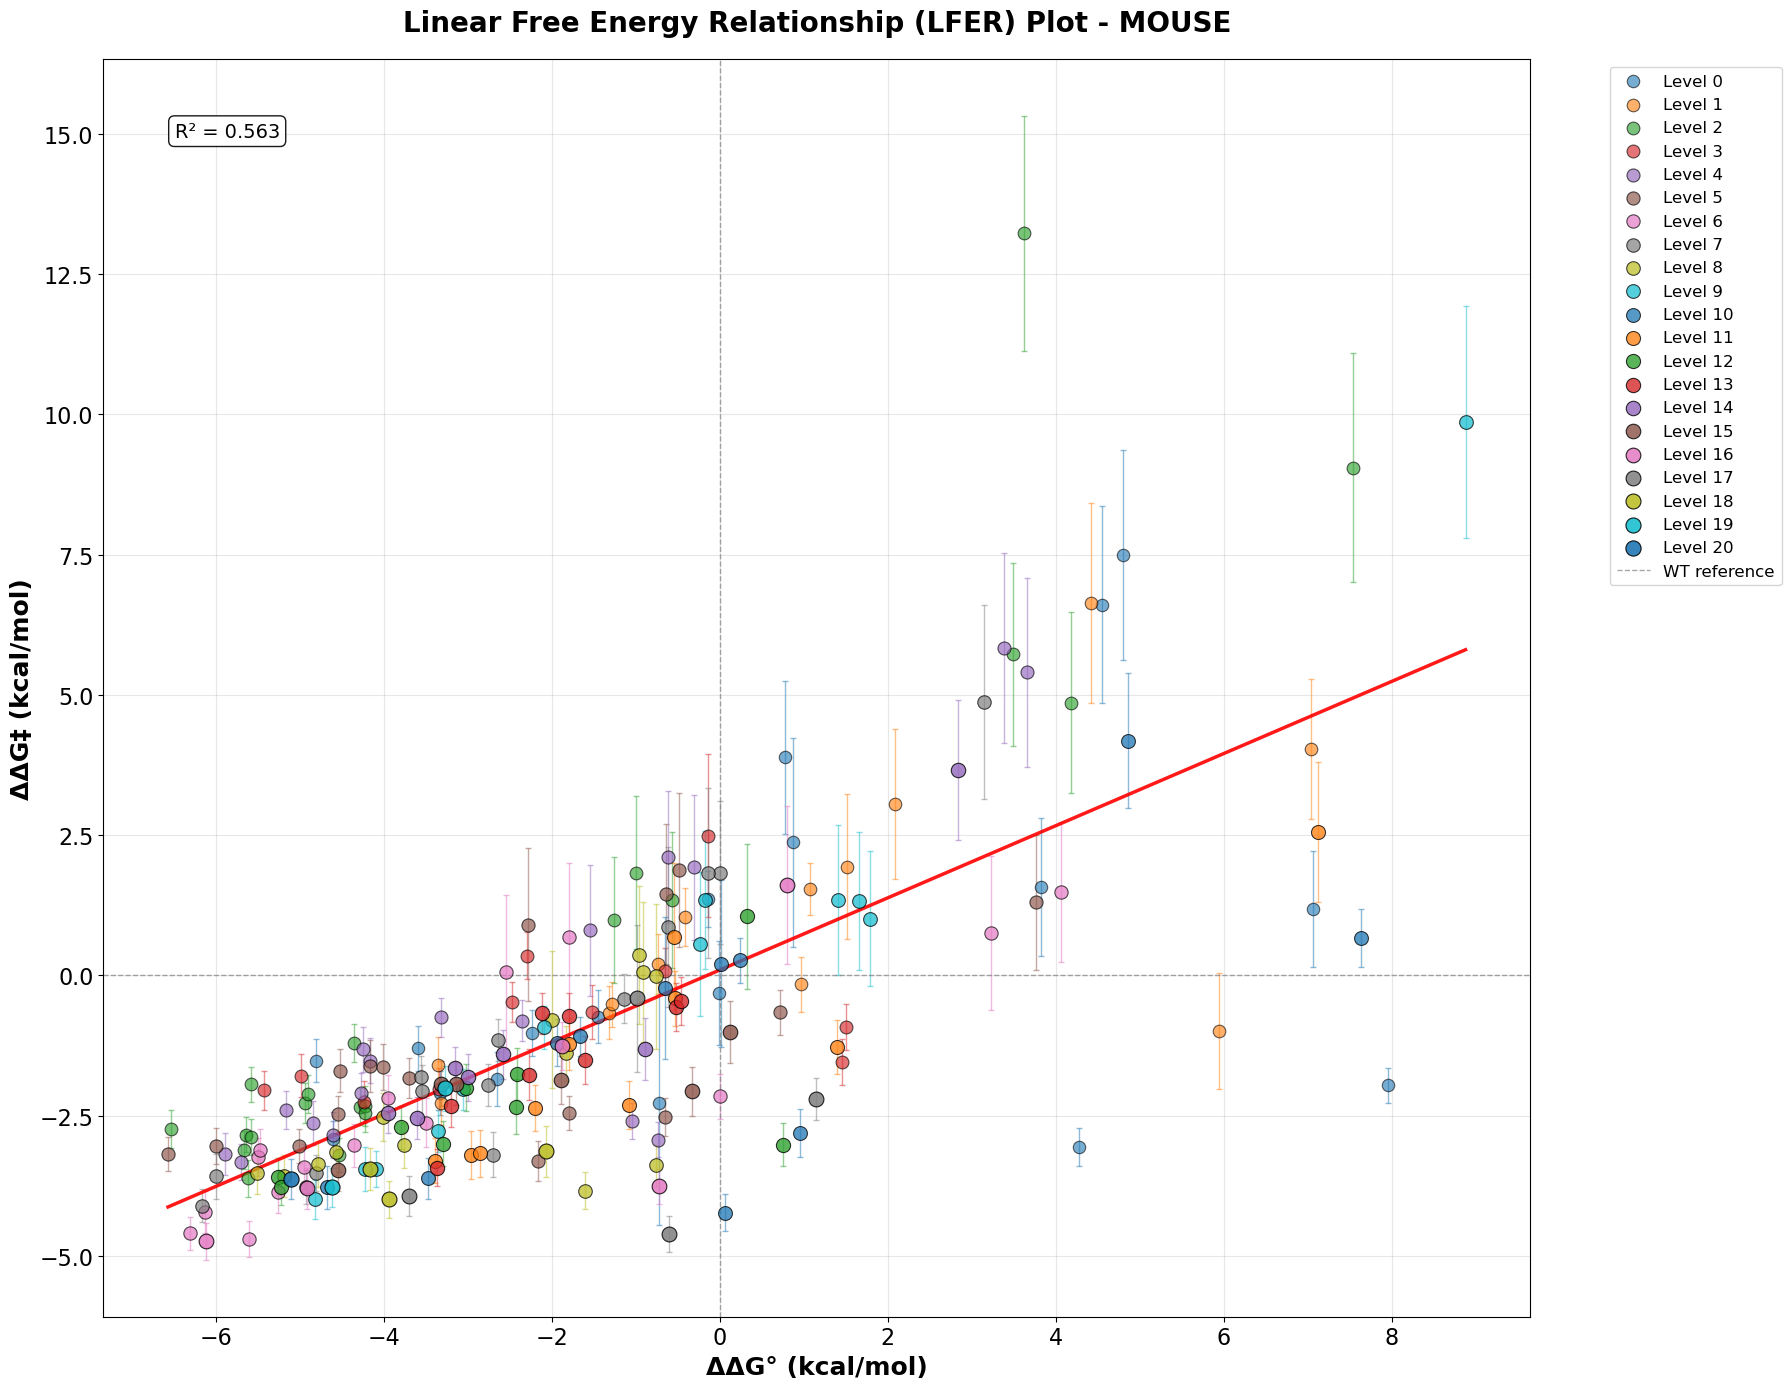


--- ENHANCED ΔΔG PLOT SUMMARY ---
Wild-type reference: mousecys (ΔG‡=17.68, ΔG°=-56.96)
Levels in your data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]
Total data points: 215
Points per level:
  Level 0: 18 points
  Level 1: 13 points
  Level 2: 20 points
  Level 3: 11 points
  Level 4: 17 points
  Level 5: 16 points
  Level 6: 15 points
  Level 7: 14 points
  Level 8: 13 points
  Level 9: 12 points
  Level 10: 11 points
  Level 11: 10 points
  Level 12: 9 points
  Level 13: 8 points
  Level 14: 7 points
  Level 15: 6 points
  Level 16: 5 points
  Level 17: 4 points
  Level 18: 3 points
  Level 19: 2 points
  Level 20: 1 points

ΔΔG value ranges:
  ΔΔG‡: -4.74 to 13.23 kcal/mol
  ΔΔG°: -6.57 to 8.88 kcal/mol

--- ERROR BAR SUMMARY ---
Applied scal

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats
from scipy.stats import linregress
import re
import os

def extract_level_number(level_str):
    """Extract numeric level from level string - improved version"""
    import re
    
    if pd.isna(level_str):
        return None
    
    # Convert to string if not already
    level_str = str(level_str).lower().strip()
    
    # Try different patterns
    patterns = [
        r'level\s*(\d+)',  # level0, level 0, level_0
        r'lvl\s*(\d+)',    # lvl0, lvl 0
        r'^(\d+)$',        # just a number
        r'(\d+)',          # any number in the string
    ]
    
    for pattern in patterns:
        match = re.search(pattern, level_str)
        if match:
            return int(match.group(1))
    
    return None

def parse_value_with_error(value_str):
    """
    Parse a string like '15.59 ± 0.94' and return (value, error)
    If no error is found, return (value, 0.0)
    """
    if pd.isna(value_str):
        return None, None
    
    value_str = str(value_str).strip()
    
    # Look for pattern: number ± number
    pattern = r'(-?\d+\.?\d*)\s*[±]\s*(\d+\.?\d*)'
    match = re.search(pattern, value_str)
    
    if match:
        value = float(match.group(1))
        error = float(match.group(2))
        return value, error
    else:
        # Try to extract just the number if no ± found
        number_pattern = r'(-?\d+\.?\d*)'
        number_match = re.search(number_pattern, value_str)
        if number_match:
            value = float(number_match.group(1))
            return value, 0.0
        else:
            return None, None

def create_enhanced_ddg_lfer_plot(csv_path, wt_values=None, save_paths=None, add_labels=False, error_scale_factor=0.3):
    """
    Create ΔΔG‡ vs ΔΔG° LFER plot relative to wild-type with only vertical error bars
    
    Parameters:
    csv_path (str): Path to the CSV file
    wt_values (dict): Dictionary with wild-type values {'dg_star': value, 'dg0': value, 'dg_star_error': value, 'dg0_error': value}
    save_paths (list): List of directory paths where the plot should be saved
    add_labels (bool): Whether to add mutation labels to points (set to False)
    error_scale_factor (float): Scale factor for error bars (0.3 = much smaller bars)
    """
    
    # Default wild-type values if not provided
    if wt_values is None:
        wt_values = {
            'dg_star': 17.68,
            'dg0': -56.96,
            'dg_star_error': 0.91,
            'dg0_error': 1.03
        }
    
    print(f"Using wild-type reference values:")
    print(f"  ΔG‡_WT = {wt_values['dg_star']:.2f} ± {wt_values['dg_star_error']:.2f} kcal/mol")
    print(f"  ΔG°_WT = {wt_values['dg0']:.2f} ± {wt_values['dg0_error']:.2f} kcal/mol")
    
    # Load data
    df = pd.read_csv(csv_path)
    print(f"\nLoaded {len(df)} rows from CSV")
    
    # Show all column names to help debug
    print(f"\nAll columns in CSV:")
    for i, col in enumerate(df.columns):
        print(f"  {i}: '{col}'")
    
    # Check for raw data columns that might contain error information
    raw_columns = [col for col in df.columns if 'raw' in col.lower()]
    print(f"\nFound raw data columns: {raw_columns}")
    
    # Parse raw data columns to extract values and errors
    if 'dG_star_raw' in df.columns:
        print("Parsing dG_star_raw column...")
        df[['dg_star_parsed', 'dg_star_stderr']] = df['dG_star_raw'].apply(
            lambda x: pd.Series(parse_value_with_error(x))
        )
        # Show some examples
        print("First 5 dG_star_raw parsing results:")
        for i in range(min(5, len(df))):
            original = df.iloc[i]['dG_star_raw']
            parsed_val = df.iloc[i]['dg_star_parsed']
            parsed_err = df.iloc[i]['dg_star_stderr']
            print(f"  '{original}' -> value: {parsed_val}, error: {parsed_err}")
    
    if 'dG0_raw' in df.columns:
        print("\nParsing dG0_raw column...")
        df[['dg0_parsed', 'dg0_stderr']] = df['dG0_raw'].apply(
            lambda x: pd.Series(parse_value_with_error(x))
        )
        # Show some examples
        print("First 5 dG0_raw parsing results:")
        for i in range(min(5, len(df))):
            original = df.iloc[i]['dG0_raw']
            parsed_val = df.iloc[i]['dg0_parsed']
            parsed_err = df.iloc[i]['dg0_stderr']
            print(f"  '{original}' -> value: {parsed_val}, error: {parsed_err}")
    
    # Standardize column names - now prioritize parsed values
    column_mapping = {
        'Mean_dG_star': 'dg_star_mean',
        'Mean_dG0': 'dg0_mean', 
        'Mutation': 'mutation',
        'mean_dg_star': 'dg_star_mean',
        'mean_dg0': 'dg0_mean',
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            print(f"Renaming: '{old_name}' -> '{new_name}'")
            df = df.rename(columns={old_name: new_name})
    
    # Decide which values to use - prefer parsed values from raw data
    if 'dg_star_parsed' in df.columns and not df['dg_star_parsed'].isna().all():
        df['dg_star'] = df['dg_star_parsed']
        print("Using parsed dG_star values from raw data")
    elif 'dg_star_mean' in df.columns:
        df['dg_star'] = df['dg_star_mean']
        print("Using mean dG_star values")
    else:
        print("ERROR: No dG_star column found!")
        return None, None, None
    
    if 'dg0_parsed' in df.columns and not df['dg0_parsed'].isna().all():
        df['dg0'] = df['dg0_parsed']
        print("Using parsed dG0 values from raw data")
    elif 'dg0_mean' in df.columns:
        df['dg0'] = df['dg0_mean']
        print("Using mean dG0 values")
    else:
        print("ERROR: No dG0 column found!")
        return None, None, None
    
    # Check for error columns
    has_dg_star_error = 'dg_star_stderr' in df.columns and not df['dg_star_stderr'].isna().all()
    has_dg0_error = 'dg0_stderr' in df.columns and not df['dg0_stderr'].isna().all()
    
    print(f"\nError bar availability:")
    print(f"  ΔG‡ standard error: {'Available' if has_dg_star_error else 'Not found'}")
    print(f"  ΔG° standard error: {'Available' if has_dg0_error else 'Not found'}")
    
    # Calculate ΔΔG values relative to wild-type
    print(f"\n--- CALCULATING ΔΔG VALUES ---")
    df['ddg_star'] = df['dg_star'] - wt_values['dg_star']
    df['ddg0'] = df['dg0'] - wt_values['dg0']
    
    print(f"ΔΔG‡ range: {df['ddg_star'].min():.2f} to {df['ddg_star'].max():.2f} kcal/mol")
    print(f"ΔΔG° range: {df['ddg0'].min():.2f} to {df['ddg0'].max():.2f} kcal/mol")
    
    # Calculate error propagation for ΔΔG values
    # For differences: σ(A-B) = sqrt(σ_A² + σ_B²)
    if has_dg_star_error:
        df['ddg_star_stderr'] = np.sqrt(df['dg_star_stderr']**2 + wt_values['dg_star_error']**2)
    else:
        df['ddg_star_stderr'] = wt_values['dg_star_error']  # Use WT error if no mutation errors
    
    if has_dg0_error:
        df['ddg0_stderr'] = np.sqrt(df['dg0_stderr']**2 + wt_values['dg0_error']**2)
    else:
        df['ddg0_stderr'] = wt_values['dg0_error']  # Use WT error if no mutation errors
    
    if has_dg_star_error or has_dg0_error:
        print(f"\nError propagation completed:")
        print(f"  ΔΔG‡ errors - Min: {df['ddg_star_stderr'].min():.4f}, Max: {df['ddg_star_stderr'].max():.4f}")
        print(f"  ΔΔG° errors - Min: {df['ddg0_stderr'].min():.4f}, Max: {df['ddg0_stderr'].max():.4f}")
    
    # Extract level numbers
    df['Level_Numeric'] = df['Level'].apply(extract_level_number)
    
    # Debug: Show what levels we found
    print(f"\nOriginal Level values:")
    for level in sorted(df['Level'].unique()):
        count = (df['Level'] == level).sum()
        extracted = extract_level_number(level)
        print(f"  '{level}' -> {extracted} ({count} rows)")
    
    # Clean data - include error columns if they exist
    required_cols = ['ddg_star', 'ddg0', 'mutation', 'Level_Numeric']
    df_clean = df.dropna(subset=required_cols).copy()
    
    # Handle missing error values by setting them to WT error
    if 'ddg_star_stderr' not in df_clean.columns:
        df_clean['ddg_star_stderr'] = wt_values['dg_star_error']
    df_clean['ddg_star_stderr'] = df_clean['ddg_star_stderr'].fillna(wt_values['dg_star_error'])
        
    if 'ddg0_stderr' not in df_clean.columns:
        df_clean['ddg0_stderr'] = wt_values['dg0_error']
    df_clean['ddg0_stderr'] = df_clean['ddg0_stderr'].fillna(wt_values['dg0_error'])
    
    # Apply error scaling factor (now much smaller for subtle error bars)
    df_clean['ddg_star_stderr_scaled'] = df_clean['ddg_star_stderr'] * error_scale_factor
    # No horizontal error bars - only vertical
    df_clean['ddg0_stderr_scaled'] = 0
    
    print(f"After cleaning: {len(df_clean)} rows remaining")
    
    # Debug: Check scaled error bar values
    print(f"\n--- ERROR BAR VALUES DEBUG ---")
    print(f"Applied scaling factor: {error_scale_factor}")
    print(f"ΔΔG‡ stderr (scaled) - Min: {df_clean['ddg_star_stderr_scaled'].min():.4f}, Max: {df_clean['ddg_star_stderr_scaled'].max():.4f}, Mean: {df_clean['ddg_star_stderr_scaled'].mean():.4f}")
    print(f"ΔΔG° stderr (scaled) - DISABLED (no horizontal error bars)")
    
    # Get unique levels that actually exist
    unique_levels = sorted(df_clean['Level_Numeric'].unique())
    print(f"Numeric levels found: {unique_levels}")
    
    # Create adaptive visual mapping based on actual levels
    n_levels = len(unique_levels)
    
    # Define distinct colors for levels
    level_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    if n_levels == 1:
        # Only one level - use single style
        level_alphas = [0.7]
        level_sizes = [100]
        level_colors_mapped = [level_colors[0]]
    else:
        # Multiple levels - create gradients for alpha and size, distinct colors
        level_alphas = np.linspace(0.6, 0.9, n_levels)
        level_sizes = np.linspace(80, 120, n_levels)
        level_colors_mapped = [level_colors[i % len(level_colors)] for i in range(n_levels)]
    
    # Create level to visual mapping
    level_visual_map = {}
    for i, level in enumerate(unique_levels):
        level_visual_map[level] = {
            'alpha': level_alphas[i],
            'size': level_sizes[i],
            'color': level_colors_mapped[i]
        }
    
    # Get MSA position colors (keeping your existing function)
    msa_position_colors = {
        3: "#E41A1C", 4: "#377EB8", 24: "#E41A1C", 47: "#FFFF33", 48: "#4DAF4A",
        49: "#984EA3", 52: "#FF7F00", 54: "#F781BF", 60: "#4DAF4A", 74: "#4DAF4A",
        87: "#4DAF4A", 99: "#A65628", 102: "#CAB2D6", 104: "#FDB462", 107: "#00CED1",
        139: "#1F78B4", 142: "#F781BF", 143: "#E31A1C", 144: "#FF7F00", 173: "#00CED1",
        177: "#4DAF4A", 178: "#7570B3", 181: "#F781BF"
    }
    
    # Extract positions and assign colors
    df_clean['Position'] = df_clean['mutation'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]) if re.findall(r'\d+', str(x)) else None)
    df_clean['Color'] = df_clean['Position'].map(msa_position_colors).fillna('#808080')
    
    # NO JITTER - use original coordinates to avoid overlaps
    df_clean['ddg0_jittered'] = df_clean['ddg0']  # No jitter
    df_clean['ddg_star_jittered'] = df_clean['ddg_star']  # No jitter
    
    # Create larger plot
    fig, ax = plt.subplots(1, 1, figsize=(18, 14), facecolor='white')
    
    # Plot by level with only vertical error bars
    for level in unique_levels:
        level_data = df_clean[df_clean['Level_Numeric'] == level]
        
        # Check if we have meaningful error values (using scaled values)
        has_meaningful_ddg_star_err = (level_data['ddg_star_stderr_scaled'] > 0).any()
        
        print(f"\nLevel {level} error bar info:")
        print(f"  Has meaningful ΔΔG‡ errors: {has_meaningful_ddg_star_err}")
        print(f"  Horizontal error bars: DISABLED")
        
        # Plot only vertical error bars first (so they appear behind the points)
        if has_meaningful_ddg_star_err:
            yerr = level_data['ddg_star_stderr_scaled']
            xerr = None  # No horizontal error bars
            
            print(f"  Plotting vertical-only error bars for level {level}")
            print(f"    Y-error range: {yerr.min():.3f} to {yerr.max():.3f}")
            
            ax.errorbar(level_data['ddg0_jittered'], level_data['ddg_star_jittered'], 
                       xerr=xerr, yerr=yerr,
                       fmt='none',  # No markers for error bars
                       ecolor=level_visual_map[level]['color'], 
                       alpha=0.5,  # Reduced alpha for subtlety
                       capsize=2,  # Smaller cap size
                       capthick=1,  # Thinner cap
                       elinewidth=1,  # Thinner error bar lines
                       zorder=2)  # Behind points but above grid
        
        # Plot the actual data points on top
        scatter = ax.scatter(level_data['ddg0_jittered'], level_data['ddg_star_jittered'], 
                   c=level_visual_map[level]['color'], 
                   s=level_visual_map[level]['size'],
                   alpha=level_visual_map[level]['alpha'],
                   marker='o',  # All points are circles
                   edgecolors='black', linewidth=0.8,
                   label=f'Level {level}',
                   zorder=5)  # Ensure points are on top
    
    # Add reference lines at zero (wild-type reference)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1, label='WT reference')
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    
    # Linear regression (using original non-jittered data)
    slope, intercept, r_value, p_value, std_err = linregress(df_clean['ddg0'], df_clean['ddg_star'])
    
    # Plot trend line
    x_range = np.linspace(df_clean['ddg0'].min(), df_clean['ddg0'].max(), 100)
    y_trend = slope * x_range + intercept
    ax.plot(x_range, y_trend, 'r-', linewidth=2.5, alpha=0.9, zorder=3)
    
    # Statistics - R² only, no slope or intercept
    stats_text = f'R² = {r_value**2:.3f}'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=14, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Labels and formatting - Updated for ΔΔG
    ax.set_xlabel('ΔΔG° (kcal/mol)', fontweight='bold', fontsize=18)
    ax.set_ylabel('ΔΔG‡ (kcal/mol)', fontweight='bold', fontsize=18)
    ax.set_title('Linear Free Energy Relationship (LFER) Plot - MOUSE', 
                 fontweight='bold', fontsize=20, pad=20)
    
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.tight_layout()
    
    # Save the plot if save_paths are provided
    if save_paths:
        for save_path in save_paths:
            # Create directory if it doesn't exist
            os.makedirs(save_path, exist_ok=True)
            
            # Define filename
            filename = "DDG_LFER_plot_vertical_only.png"
            full_path = os.path.join(save_path, filename)
            
            # Save with high quality
            fig.savefig(full_path, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"Enhanced ΔΔG plot saved to: {full_path}")
            
            # Also save as PDF for publications
            pdf_path = os.path.join(save_path, "DDG_LFER_plot_vertical_only.pdf")
            fig.savefig(pdf_path, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"PDF saved to: {pdf_path}")
    
    plt.show()
    
    # Print comprehensive summary
    print(f"\n--- ENHANCED ΔΔG PLOT SUMMARY ---")
    print(f"Wild-type reference: mousecys (ΔG‡={wt_values['dg_star']:.2f}, ΔG°={wt_values['dg0']:.2f})")
    print(f"Levels in your data: {unique_levels}")
    print(f"Total data points: {len(df_clean)}")
    print(f"Points per level:")
    for level in unique_levels:
        count = (df_clean['Level_Numeric'] == level).sum()
        print(f"  Level {level}: {count} points")
    
    # ΔΔG ranges
    print(f"\nΔΔG value ranges:")
    print(f"  ΔΔG‡: {df_clean['ddg_star'].min():.2f} to {df_clean['ddg_star'].max():.2f} kcal/mol")
    print(f"  ΔΔG°: {df_clean['ddg0'].min():.2f} to {df_clean['ddg0'].max():.2f} kcal/mol")
    
    # Error bar summary
    print(f"\n--- ERROR BAR SUMMARY ---")
    print(f"Applied scaling factor: {error_scale_factor}")
    print(f"ERROR BAR CONFIGURATION: VERTICAL ONLY")
    mean_ddg_star_err = df_clean['ddg_star_stderr_scaled'].mean()
    max_ddg_star_err = df_clean['ddg_star_stderr_scaled'].max()
    print(f"ΔΔG‡ standard error (scaled) - Mean: {mean_ddg_star_err:.4f}, Max: {max_ddg_star_err:.4f} kcal/mol")
    print(f"ΔΔG° standard error: DISABLED (no horizontal error bars)")
    
    print(f"\n--- MODIFICATIONS MADE ---")
    print(f"1. ✓ Converted to ΔΔG values relative to wild-type mousecys")
    print(f"2. ✓ Error bars: VERTICAL ONLY (with error propagation)")
    print(f"3. ✓ Overlaps: REMOVED (no jitter applied)")
    print(f"4. ✓ Labels: REMOVED (add_labels=False)")
    print(f"5. ✓ Error scaling factor: {error_scale_factor}")
    print(f"6. ✓ Added reference lines at zero (wild-type)")
    print(f"7. ✓ Label shows: R² ONLY")
    
    return fig, ax, df_clean

# Example usage with ΔΔG values relative to wild-type:
if __name__ == "__main__":
    csv_path = "/home/hp/results/MOUSE/distance_analysis_data.csv"
    save_paths = [
        "/home/hp/nayanika/github/GPX6/figures",
        "/home/hp/nayanika/github/Article-GPX6-EVB/Figures"
    ]
    
    # Wild-type mousecys values
    wt_values = {
        'dg_star': 17.68,
        'dg0': -56.96,
        'dg_star_error': 0.91,
        'dg0_error': 1.03
    }
    
    # Create plot with ΔΔG values relative to wild-type
    print("Creating enhanced ΔΔG plot relative to wild-type mousecys...")
    fig, ax, data = create_enhanced_ddg_lfer_plot(csv_path, wt_values=wt_values, 
                                                  save_paths=save_paths, 
                                                  add_labels=False, 
                                                  error_scale_factor=0.3)